In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
latent_dim = 20
beta = 1  # β parameter - controls disentanglement


# Low beta : Good Reconstruction
# High beta : Good Generation
# usually KL divergence increases ( since inital step estimates are random that is less initallly)


learning_rate = 1e-3
epochs = 30

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to 784
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


In [3]:
# Define β-VAE model
class BetaVAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20, hidden_dim=400):
        super(BetaVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output between 0 and 1
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
# Initialize model
model = BetaVAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
# Loss function for β-VAE
def loss_function(recon_x, x, mu, logvar, beta=4.0):
    # Reconstruction loss (binary cross entropy for MNIST)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + beta * KLD, BCE, KLD

In [6]:
# Training function
def train(epoch):
    model.train()
    train_loss = 0
    bce_loss = 0
    kld_loss = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (data, _) in enumerate(pbar):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar, beta)
        
        loss.backward()
        train_loss += loss.item()
        bce_loss += bce.item()
        kld_loss += kld.item()
        
        optimizer.step()
        
        if batch_idx % 100 == 0:
            pbar.set_postfix({'Loss': loss.item()/len(data), 
                             'BCE': bce.item()/len(data),
                             'KLD': kld.item()/len(data)})
    
    return train_loss / len(train_loader.dataset), bce_loss / len(train_loader.dataset), kld_loss / len(train_loader.dataset)

# Test function
def test():
    model.eval()
    test_loss = 0
    bce_loss = 0
    kld_loss = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, bce, kld = loss_function(recon_batch, data, mu, logvar, beta)
            
            test_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
    
    return test_loss / len(test_loader.dataset), bce_loss / len(test_loader.dataset), kld_loss / len(test_loader.dataset)


In [7]:
# Training loop
train_losses, test_losses = [], []
train_bces, test_bces = [], []
train_klds, test_klds = [], []

print(f"Training β-VAE with β={beta} for {epochs} epochs...")
for epoch in range(1, epochs + 1):
    train_loss, train_bce, train_kld = train(epoch)
    test_loss, test_bce, test_kld = test()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_bces.append(train_bce)
    test_bces.append(test_bce)
    train_klds.append(train_kld)
    test_klds.append(test_kld)
    
    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    print(f'  Train BCE: {train_bce:.4f}, KLD: {train_kld:.4f}')
    print(f'  Test BCE: {test_bce:.4f}, KLD: {test_kld:.4f}')


Training β-VAE with β=1 for 30 epochs...


Epoch 1: 100%|██████████| 469/469 [00:07<00:00, 64.12it/s, Loss=143, BCE=132, KLD=11.6] 


Epoch 1: Train Loss: 176.5768, Test Loss: 138.5276
  Train BCE: 169.2026, KLD: 7.3742
  Test BCE: 125.9403, KLD: 12.5873


Epoch 2: 100%|██████████| 469/469 [00:06<00:00, 69.68it/s, Loss=126, BCE=111, KLD=14.7]


Epoch 2: Train Loss: 128.7003, Test Loss: 121.2210
  Train BCE: 114.6437, KLD: 14.0566
  Test BCE: 106.2834, KLD: 14.9377


Epoch 3: 100%|██████████| 469/469 [00:06<00:00, 68.21it/s, Loss=116, BCE=100, KLD=15.9] 


Epoch 3: Train Loss: 117.9921, Test Loss: 114.0784
  Train BCE: 102.1469, KLD: 15.8452
  Test BCE: 97.5714, KLD: 16.5070


Epoch 4: 100%|██████████| 469/469 [00:06<00:00, 68.77it/s, Loss=116, BCE=99.4, KLD=17.1]


Epoch 4: Train Loss: 113.0811, Test Loss: 110.5707
  Train BCE: 96.2025, KLD: 16.8785
  Test BCE: 92.9776, KLD: 17.5931


Epoch 5: 100%|██████████| 469/469 [00:06<00:00, 69.11it/s, Loss=110, BCE=92.4, KLD=17.6]


Epoch 5: Train Loss: 110.4545, Test Loss: 108.8226
  Train BCE: 93.1547, KLD: 17.2998
  Test BCE: 91.1354, KLD: 17.6872


Epoch 6: 100%|██████████| 469/469 [00:06<00:00, 69.57it/s, Loss=112, BCE=94, KLD=17.8]  


Epoch 6: Train Loss: 108.8298, Test Loss: 107.5394
  Train BCE: 91.2924, KLD: 17.5374
  Test BCE: 90.0184, KLD: 17.5210


Epoch 7: 100%|██████████| 469/469 [00:06<00:00, 69.17it/s, Loss=106, BCE=88.6, KLD=17.9]


Epoch 7: Train Loss: 107.4670, Test Loss: 106.6552
  Train BCE: 89.7154, KLD: 17.7516
  Test BCE: 89.1283, KLD: 17.5269


Epoch 8: 100%|██████████| 469/469 [00:06<00:00, 69.15it/s, Loss=109, BCE=90.1, KLD=18.5]


Epoch 8: Train Loss: 106.4518, Test Loss: 105.8079
  Train BCE: 88.5133, KLD: 17.9385
  Test BCE: 88.2141, KLD: 17.5938


Epoch 9: 100%|██████████| 469/469 [00:06<00:00, 69.12it/s, Loss=105, BCE=86.5, KLD=18.4]


Epoch 9: Train Loss: 105.5436, Test Loss: 105.0023
  Train BCE: 87.3962, KLD: 18.1475
  Test BCE: 87.0952, KLD: 17.9071


Epoch 10: 100%|██████████| 469/469 [00:06<00:00, 69.20it/s, Loss=101, BCE=82.1, KLD=18.9]


Epoch 10: Train Loss: 104.7559, Test Loss: 104.4354
  Train BCE: 86.4142, KLD: 18.3417
  Test BCE: 86.0846, KLD: 18.3507


Epoch 11: 100%|██████████| 469/469 [00:06<00:00, 69.71it/s, Loss=103, BCE=84.8, KLD=18.5]


Epoch 11: Train Loss: 104.0861, Test Loss: 103.8057
  Train BCE: 85.5641, KLD: 18.5219
  Test BCE: 85.1309, KLD: 18.6748


Epoch 12: 100%|██████████| 469/469 [00:06<00:00, 69.19it/s, Loss=98.8, BCE=80, KLD=18.8] 


Epoch 12: Train Loss: 103.4393, Test Loss: 103.3823
  Train BCE: 84.7721, KLD: 18.6672
  Test BCE: 84.3051, KLD: 19.0772


Epoch 13: 100%|██████████| 469/469 [00:06<00:00, 69.35it/s, Loss=107, BCE=87.2, KLD=19.5]


Epoch 13: Train Loss: 102.8979, Test Loss: 102.7351
  Train BCE: 84.0428, KLD: 18.8551
  Test BCE: 84.1182, KLD: 18.6169


Epoch 14: 100%|██████████| 469/469 [00:06<00:00, 69.27it/s, Loss=100, BCE=81.6, KLD=18.9]


Epoch 14: Train Loss: 102.3229, Test Loss: 102.7470
  Train BCE: 83.3415, KLD: 18.9813
  Test BCE: 83.4551, KLD: 19.2919


Epoch 15: 100%|██████████| 469/469 [00:06<00:00, 69.60it/s, Loss=102, BCE=83.1, KLD=18.7] 


Epoch 15: Train Loss: 101.8879, Test Loss: 102.3230
  Train BCE: 82.8309, KLD: 19.0570
  Test BCE: 83.1249, KLD: 19.1981


Epoch 16: 100%|██████████| 469/469 [00:06<00:00, 69.28it/s, Loss=99, BCE=80.1, KLD=18.9]  


Epoch 16: Train Loss: 101.5993, Test Loss: 102.0430
  Train BCE: 82.4573, KLD: 19.1420
  Test BCE: 82.9249, KLD: 19.1181


Epoch 17: 100%|██████████| 469/469 [00:06<00:00, 68.30it/s, Loss=101, BCE=81.9, KLD=19]   


Epoch 17: Train Loss: 101.2337, Test Loss: 101.5847
  Train BCE: 82.0394, KLD: 19.1943
  Test BCE: 82.3915, KLD: 19.1932


Epoch 18: 100%|██████████| 469/469 [00:06<00:00, 68.95it/s, Loss=99.9, BCE=80.5, KLD=19.5]


Epoch 18: Train Loss: 100.9470, Test Loss: 101.4000
  Train BCE: 81.6734, KLD: 19.2736
  Test BCE: 82.0534, KLD: 19.3466


Epoch 19: 100%|██████████| 469/469 [00:06<00:00, 69.63it/s, Loss=97.3, BCE=78.2, KLD=19.1]


Epoch 19: Train Loss: 100.6341, Test Loss: 101.5277
  Train BCE: 81.3077, KLD: 19.3264
  Test BCE: 82.0688, KLD: 19.4589


Epoch 20: 100%|██████████| 469/469 [00:06<00:00, 69.29it/s, Loss=97.9, BCE=79.3, KLD=18.6]


Epoch 20: Train Loss: 100.4569, Test Loss: 101.2929
  Train BCE: 81.0959, KLD: 19.3611
  Test BCE: 82.1237, KLD: 19.1692


Epoch 21: 100%|██████████| 469/469 [00:06<00:00, 69.24it/s, Loss=104, BCE=84.4, KLD=19.2] 


Epoch 21: Train Loss: 100.2701, Test Loss: 100.6834
  Train BCE: 80.8545, KLD: 19.4155
  Test BCE: 81.1590, KLD: 19.5244


Epoch 22: 100%|██████████| 469/469 [00:06<00:00, 68.90it/s, Loss=104, BCE=84.4, KLD=19.8] 


Epoch 22: Train Loss: 100.0168, Test Loss: 100.7105
  Train BCE: 80.5875, KLD: 19.4292
  Test BCE: 81.4771, KLD: 19.2334


Epoch 23: 100%|██████████| 469/469 [00:06<00:00, 69.22it/s, Loss=99.3, BCE=79.7, KLD=19.6]


Epoch 23: Train Loss: 99.8824, Test Loss: 100.6480
  Train BCE: 80.3809, KLD: 19.5015
  Test BCE: 81.1608, KLD: 19.4872


Epoch 24: 100%|██████████| 469/469 [00:06<00:00, 69.64it/s, Loss=99.3, BCE=79.9, KLD=19.4]


Epoch 24: Train Loss: 99.6815, Test Loss: 100.4159
  Train BCE: 80.1735, KLD: 19.5080
  Test BCE: 81.2512, KLD: 19.1647


Epoch 25: 100%|██████████| 469/469 [00:06<00:00, 69.52it/s, Loss=96.7, BCE=77.4, KLD=19.2]


Epoch 25: Train Loss: 99.5105, Test Loss: 100.4725
  Train BCE: 79.9663, KLD: 19.5442
  Test BCE: 80.8671, KLD: 19.6055


Epoch 26: 100%|██████████| 469/469 [00:06<00:00, 69.15it/s, Loss=95.6, BCE=76.1, KLD=19.5]


Epoch 26: Train Loss: 99.3382, Test Loss: 100.5601
  Train BCE: 79.7898, KLD: 19.5484
  Test BCE: 81.0159, KLD: 19.5442


Epoch 27: 100%|██████████| 469/469 [00:06<00:00, 70.05it/s, Loss=98.7, BCE=78.6, KLD=20.1]


Epoch 27: Train Loss: 99.2579, Test Loss: 100.3674
  Train BCE: 79.6750, KLD: 19.5828
  Test BCE: 81.0140, KLD: 19.3534


Epoch 28: 100%|██████████| 469/469 [00:06<00:00, 69.85it/s, Loss=103, BCE=82.9, KLD=20.2] 


Epoch 28: Train Loss: 99.0838, Test Loss: 100.2452
  Train BCE: 79.4920, KLD: 19.5918
  Test BCE: 80.6155, KLD: 19.6297


Epoch 29: 100%|██████████| 469/469 [00:06<00:00, 69.37it/s, Loss=97.9, BCE=77.8, KLD=20]  


Epoch 29: Train Loss: 98.9716, Test Loss: 100.1145
  Train BCE: 79.3360, KLD: 19.6355
  Test BCE: 80.6727, KLD: 19.4418


Epoch 30: 100%|██████████| 469/469 [00:06<00:00, 68.93it/s, Loss=103, BCE=82.9, KLD=20]   


Epoch 30: Train Loss: 98.8733, Test Loss: 100.0009
  Train BCE: 79.2173, KLD: 19.6560
  Test BCE: 80.3832, KLD: 19.6177


In [8]:
# Visualization functions
def visualize_reconstructions():
    """Visualize original and reconstructed images"""
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:8].to(device)
        recon, _, _ = model(data)
        
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            # Original
            axes[0, i].imshow(data[i].cpu().reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title('Original')
            
            # Reconstructed
            axes[1, i].imshow(recon[i].cpu().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title('Reconstructed')
        
        plt.suptitle(f'β-VAE Reconstructions (β={beta})')
        plt.tight_layout()
        plt.show()

def visualize_latent_space():
    """Visualize 2D projection of latent space"""
    if latent_dim < 2:
        print("Latent dimension too small for visualization")
        return
    
    model.eval()
    latents = []
    labels = []
    
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu())
            labels.append(label)
    
    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    # Use first 2 dimensions for visualization
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digit')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(f'Latent Space Visualization (β={beta})')
    plt.grid(True, alpha=0.3)
    plt.show()

In [9]:
def generate_samples():
    """Generate new samples from random latent vectors"""
    model.eval()
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(64, latent_dim).to(device)
        samples = model.decode(z)
        
        fig, axes = plt.subplots(8, 8, figsize=(12, 12))
        for i in range(64):
            ax = axes[i // 8, i % 8]
            ax.imshow(samples[i].cpu().reshape(28, 28), cmap='gray')
            ax.axis('off')
        
        plt.suptitle(f'Generated Samples from Random Latent Vectors (β={beta})')
        plt.tight_layout()
        plt.show()

def interpolate_latent():
    """Interpolate between two points in latent space"""
    model.eval()
    with torch.no_grad():
        # Get two random samples from test set
        data, _ = next(iter(test_loader))
        data = data[:2].to(device)
        
        mu, _ = model.encode(data)
        
        # Create interpolation
        steps = 10
        interpolations = []
        for alpha in np.linspace(0, 1, steps):
            z = (1 - alpha) * mu[0] + alpha * mu[1]
            recon = model.decode(z.unsqueeze(0))
            interpolations.append(recon.squeeze())
        
        fig, axes = plt.subplots(1, steps, figsize=(15, 3))
        for i, img in enumerate(interpolations):
            axes[i].imshow(img.cpu().reshape(28, 28), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'α={i/(steps-1):.1f}')
        
        plt.suptitle(f'Latent Space Interpolation (β={beta})')
        plt.tight_layout()
        plt.show()

def traverse_latent_dimension():
    """Traverse individual latent dimensions"""
    model.eval()
    with torch.no_grad():
        # Start from mean latent vector
        z = torch.zeros(1, latent_dim).to(device)
        
        # Create traversal for first 8 dimensions
        n_dims = min(8, latent_dim)
        fig, axes = plt.subplots(n_dims, 11, figsize=(15, n_dims*1.5))
        
        for dim in range(n_dims):
            values = np.linspace(-3, 3, 11)
            for i, val in enumerate(values):
                z_traverse = z.clone()
                z_traverse[0, dim] = val
                recon = model.decode(z_traverse)
                
                ax = axes[dim, i] if n_dims > 1 else axes[i]
                ax.imshow(recon[0].cpu().reshape(28, 28), cmap='gray')
                ax.axis('off')
                
                if dim == 0:
                    ax.set_title(f'{val:.1f}')
            
            if dim == n_dims - 1:
                axes[dim, 0].set_ylabel(f'Dim {dim+1}')
        
        plt.suptitle(f'Latent Dimension Traversal (β={beta})')
        plt.tight_layout()
        plt.show()

# Plot training history
def plot_training_history():
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    epochs_range = range(1, len(train_losses) + 1)
    
    # Total Loss
    axes[0].plot(epochs_range, train_losses, label='Train', linewidth=2)
    axes[0].plot(epochs_range, test_losses, label='Test', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Total Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # BCE Loss
    axes[1].plot(epochs_range, train_bces, label='Train', linewidth=2)
    axes[1].plot(epochs_range, test_bces, label='Test', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('BCE Loss')
    axes[1].set_title('Reconstruction Loss (BCE)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # KLD Loss
    axes[2].plot(epochs_range, train_klds, label='Train', linewidth=2)
    axes[2].plot(epochs_range, test_klds, label='Test', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('KLD Loss')
    axes[2].set_title(f'KL Divergence (β={beta})')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Visualizing Results...


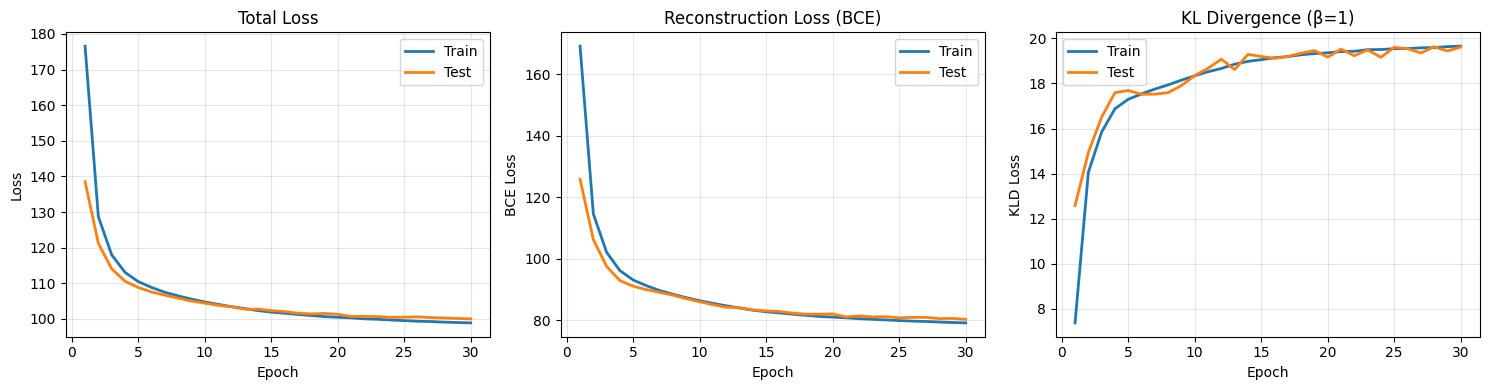

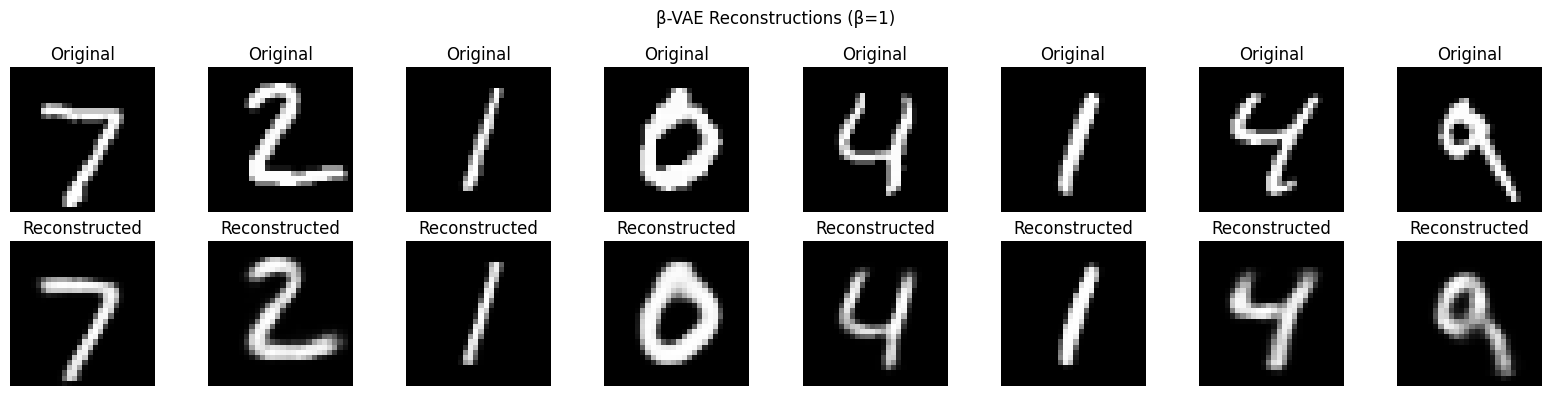

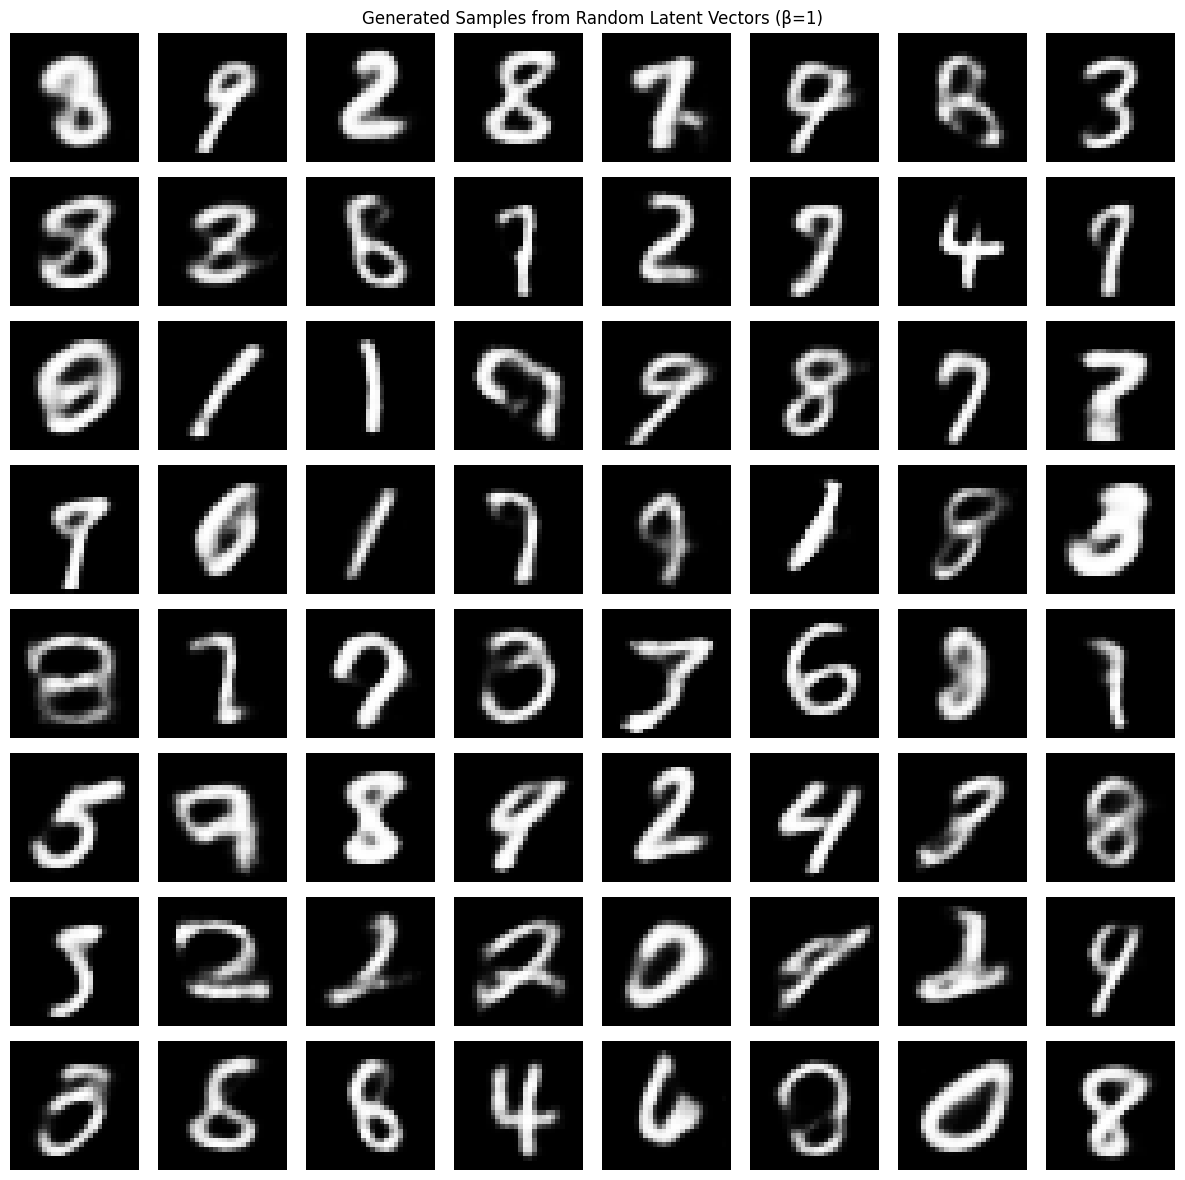

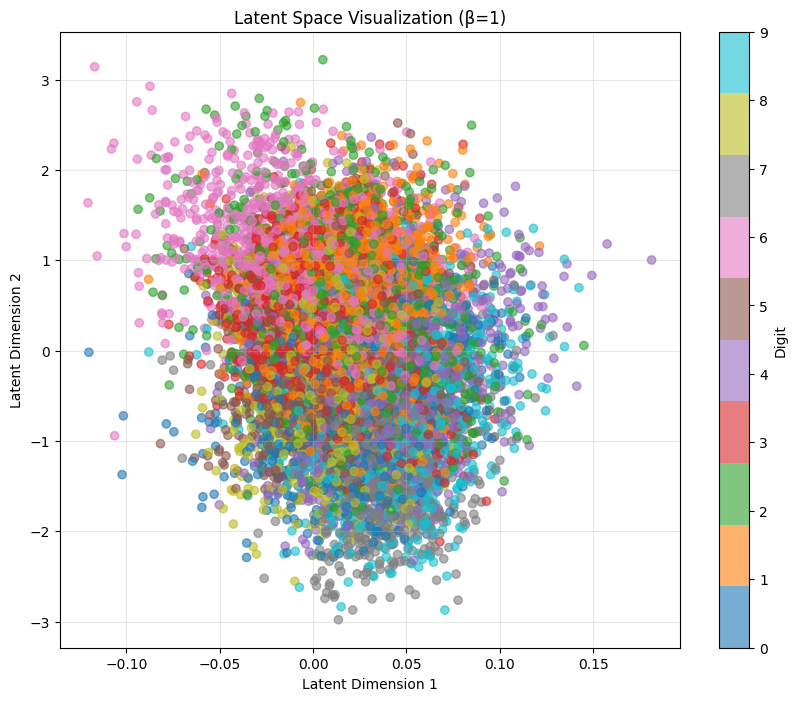

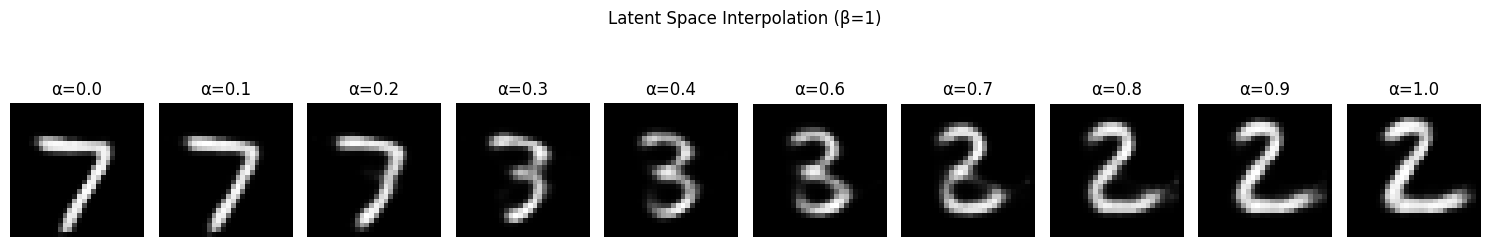

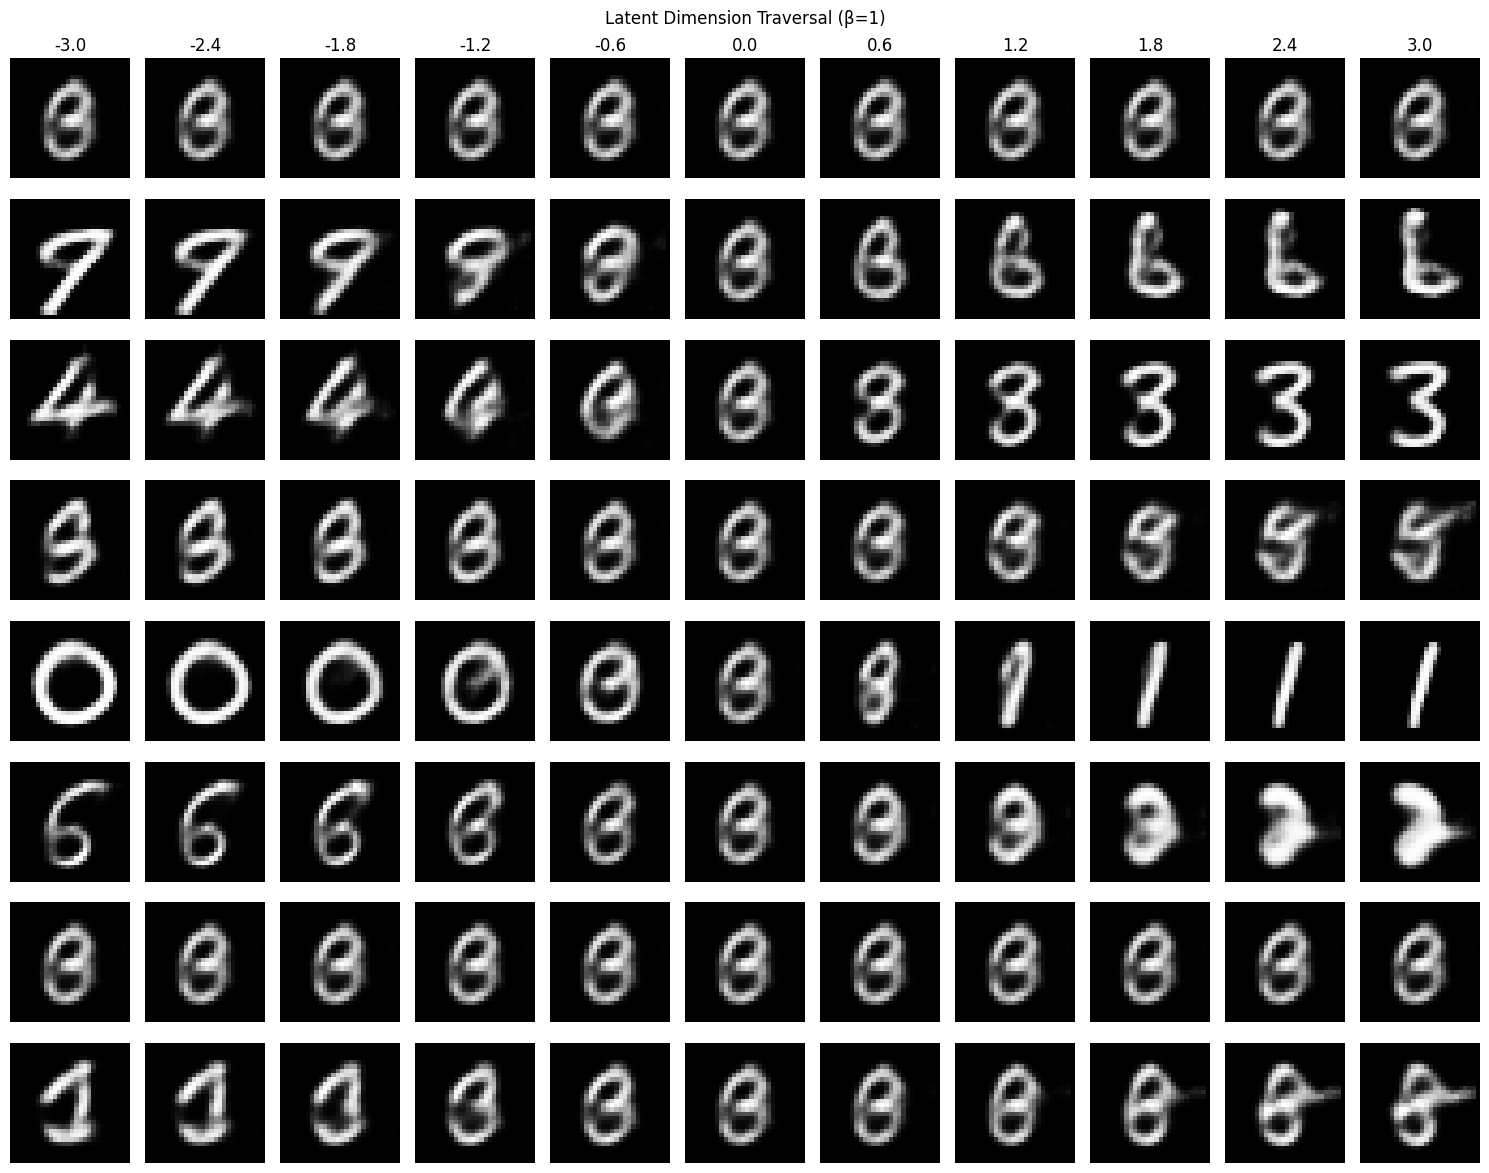


Model saved as 'beta_vae_beta1.pth'


In [10]:
# Run visualizations
print("\n" + "="*50)
print("Visualizing Results...")
print("="*50)

# Plot training history
plot_training_history()

# Show reconstructions
visualize_reconstructions()

# Show generated samples
generate_samples()

# Visualize latent space if dimension >= 2
if latent_dim >= 2:
    visualize_latent_space()

# Interpolation
interpolate_latent()

# Latent dimension traversal
traverse_latent_dimension()

# Save model
torch.save(model.state_dict(), f'beta_vae_beta{beta}.pth')
print(f"\nModel saved as 'beta_vae_beta{beta}.pth'")